In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
from pymc.model.transform.optimization import freeze_dims_and_data

from pymc_marketing.mmm import GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.multidimensional import MMM

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [13, 15]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
MMM

pymc_marketing.mmm.multidimensional.MMM

In [4]:
GeometricAdstock

pymc_marketing.mmm.components.adstock.GeometricAdstock

In [5]:
# Generate a date range
date_range = pd.date_range(start="2023-01-01", end="2023-01-30")

# Define countries and channels
countries = ["Venezuela", "Colombia", "Chile", "Argentina"]
channels = ["a", "b"]

# Create a DataFrame
data = []
for country in countries:
    for date in date_range:
        record = [date, country, *list(np.random.randint(100, 500, size=len(channels)))]
        data.append(record)

df = pd.DataFrame(data, columns=["date", "country", *channels])
df["target"] = df[channels].sum(axis=1) + np.random.randint(100, 500, size=len(df))
df.head()

,date,country,a,b,target
0,2023-01-01,Venezuela,338,298,893
1,2023-01-02,Venezuela,190,346,710
2,2023-01-03,Venezuela,352,198,762
3,2023-01-04,Venezuela,434,235,1003
4,2023-01-05,Venezuela,477,490,1448


In [6]:
# split df in train and test
df_train = df.query("date < '2023-01-15'")
df_test = df.query("date >= '2023-01-15'")

In [7]:
from pymc_marketing.prior import Prior

# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

# Not working with hierarchical priors

In [8]:
# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

saturation = MichaelisMentenSaturation(priors=priors)

In [9]:
saturation.model_config

{'saturation_alpha': Prior("Gamma", mu=Prior("HalfNormal", sigma=1, dims="country"), sigma=Prior("HalfNormal", sigma=1, dims="country"), dims=("channel", "country")),
 'saturation_lam': Prior("HalfNormal", sigma=1, dims="channel")}

In [10]:
alpha = Prior("HalfNormal", sigma=1, dims="channel")
adstock = GeometricAdstock(l_max=2)
adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=1, beta=3)}

In [11]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    dims=("country",),
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=12,
    time_varying_media=True,
    time_varying_intercept=True,
)

In [12]:
mmm.build_model(X=df_train.drop(columns="target"), y=df_train.drop(columns=channels))

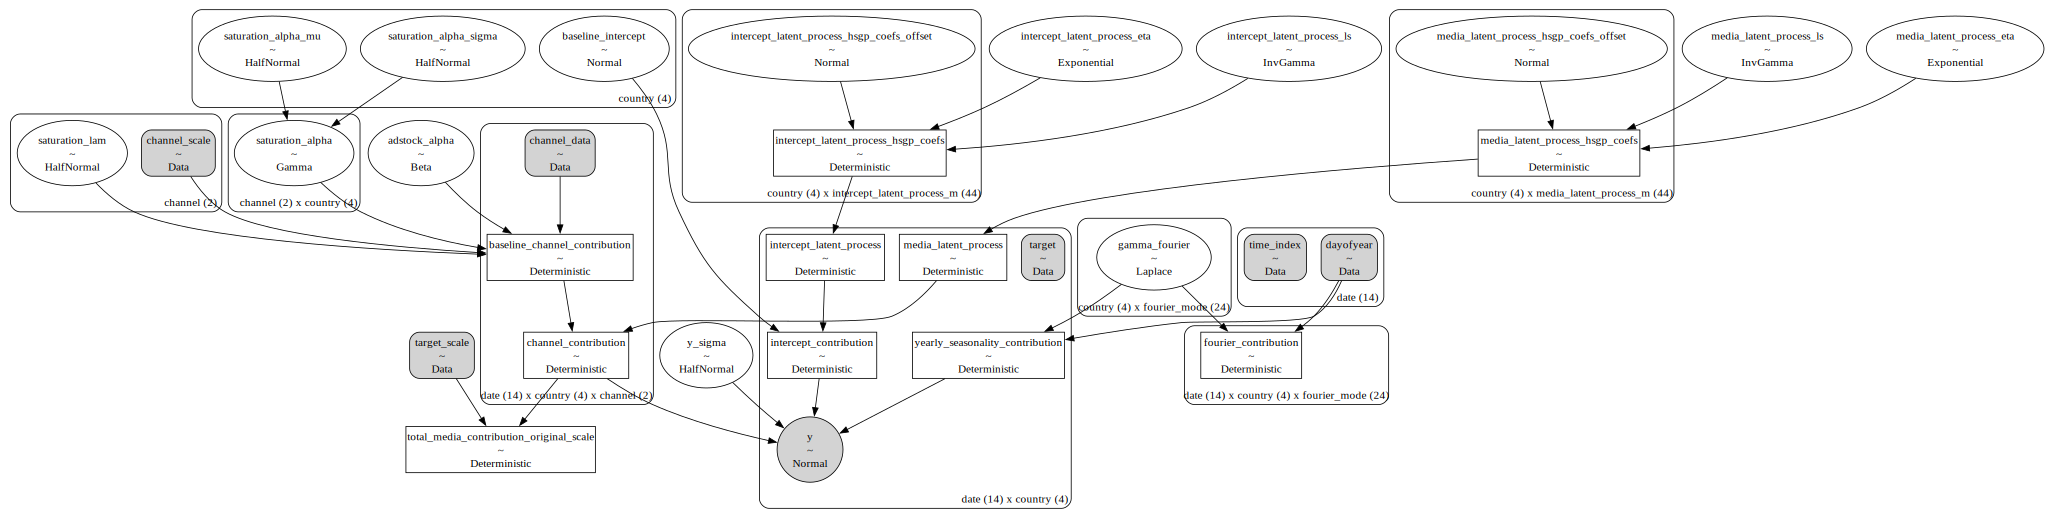

In [13]:
pm.model_to_graphviz(mmm.model)

In [14]:
mmm.add_original_scale_contribution_variable(
    var=["intercept_contribution", "channel_contribution"]
)

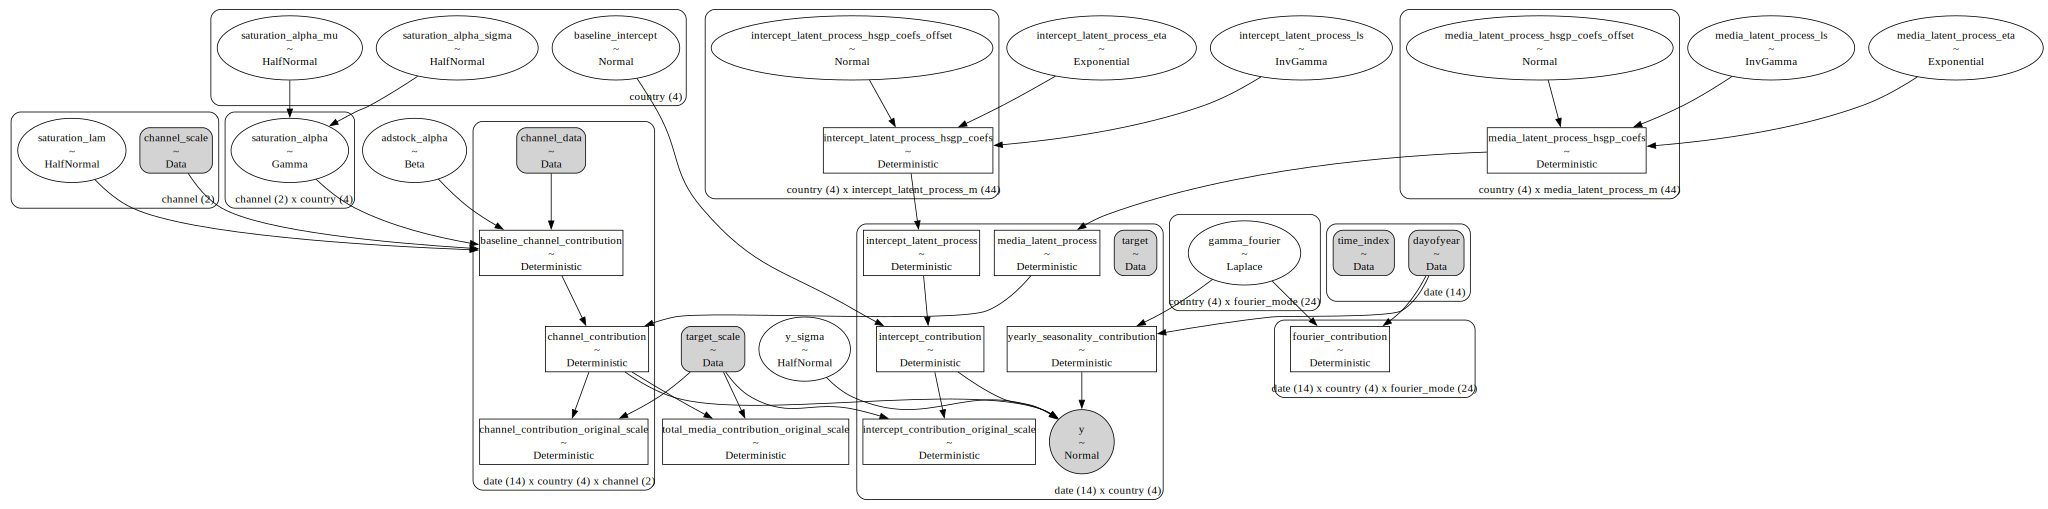

In [15]:
pm.model_to_graphviz(mmm.model)

In [16]:
pytensor.dprint(
    freeze_dims_and_data(mmm.model)["channel_contribution_original_scale"],
    depth=4,
    print_type=True,
)

Mul [id A] <Tensor3(float64, shape=(14, 4, 2))> 'channel_contribution_original_scale'
 ├─ Mul [id B] <Tensor3(float64, shape=(14, 4, 2))> 'channel_contribution'
 │  ├─ True_div [id C] <Tensor3(float64, shape=(14, 4, 2))> 'baseline_channel_contribution'
 │  │  ├─ Mul [id D] <Tensor3(float64, shape=(14, 4, 2))>
 │  │  └─ Add [id E] <Tensor3(float64, shape=(14, 4, 2))>
 │  └─ ExpandDims{axis=2} [id F] <Tensor3(float64, shape=(14, 4, 1))>
 │     └─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id G] <Matrix(float64, shape=(14, 4))> 'media_latent_process'
 └─ ExpandDims{axes=[0, 1, 2]} [id H] <Tensor3(float64, shape=(1, 1, 1))>
    └─ target_scale{1448.0} [id I] <Scalar(float64, shape=())>


In [17]:
mmm.fit(
    X=df_train.drop(columns="target"),
    y=df_train.drop(columns=channels),
    chains=4,
    target_accept=0.85,
    nuts_sampler="numpyro",
    random_seed=42,
)

mmm.sample_posterior_predictive(
    X=df_train.drop(columns="target"),
    y=None,
    extend_idata=True,
    combined=True,
    random_seed=42,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2025-01-31 14:30:07.816256: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.11 = f64[4,1000,14,4,2]{4,3,2,1,0} reduce(f64[4,1000,1,14,4,2]{5,4,3,2,1,0} %broadcast.16, f64[] %constant.31), dimensions={2}, to_apply=%region_7.208, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod" source_file="/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/tmpr0ms0tw2" source_line=145}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-01-31 14:30:08.842733: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.031511s
Constant folding an instruction is taking 

Output()

<xarray.Dataset> Size: 2MB
Dimensions:  (date: 14, country: 4, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 112B 2023-01-01 2023-01-02 ... 2023-01-14
  * country  (country) <U9 144B 'Argentina' 'Chile' 'Colombia' 'Venezuela'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, country, sample) float64 2MB 0.6558 0.4909 ... 0.6368 0.5865
Attributes:
    created_at:                 2025-01-31T12:30:09.940074+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

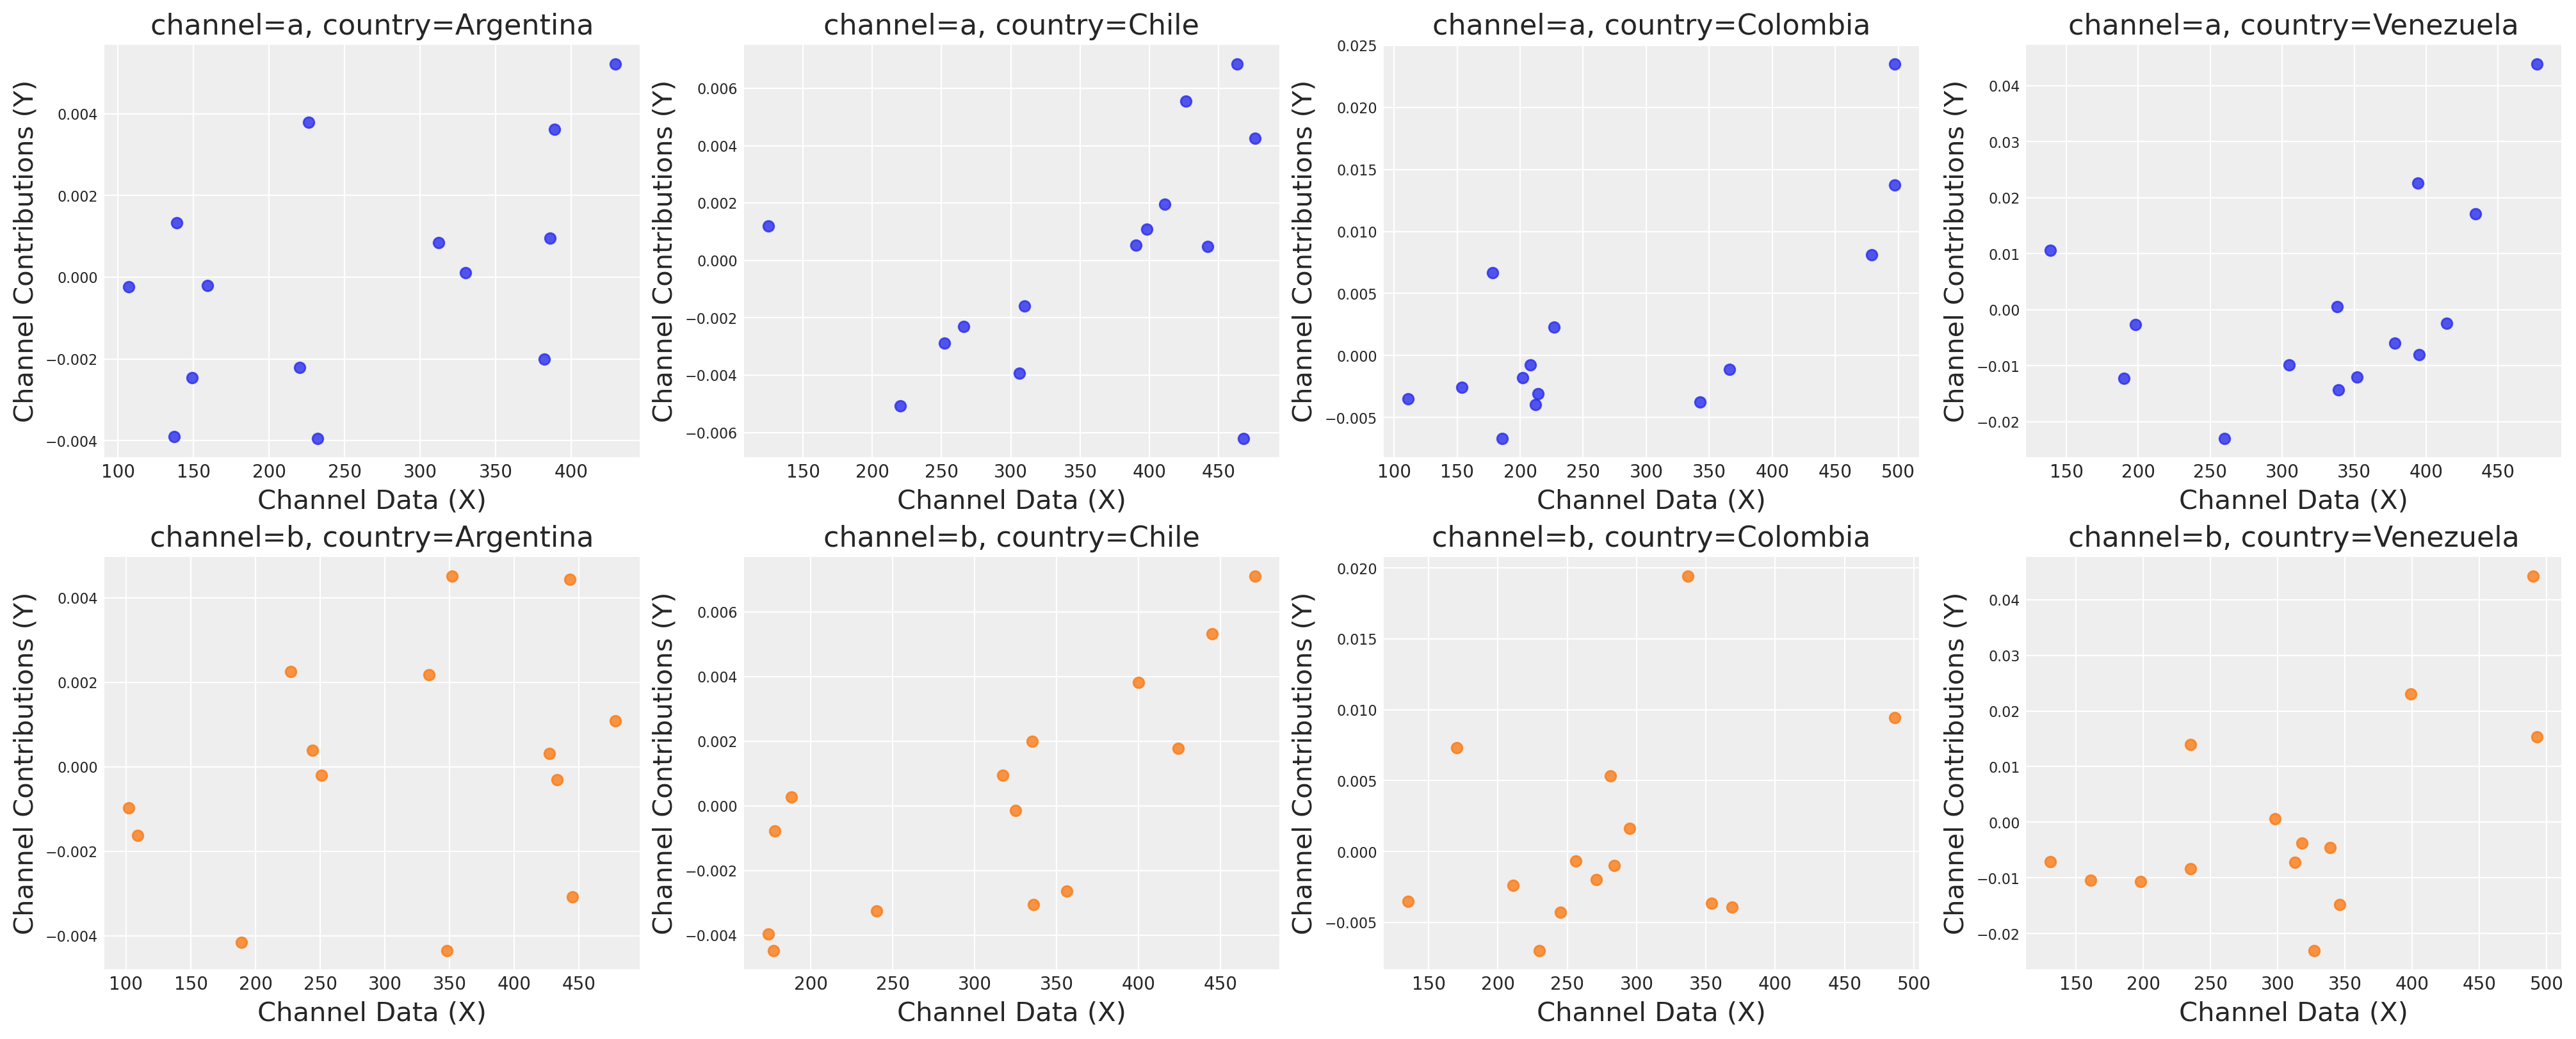

In [18]:
mmm.plot.saturation_curves_scatter();

In [19]:
_y_in_sample = mmm.sample_posterior_predictive(
    X=df_train.drop(columns="target"),
    y=None,
    extend_idata=False,
    include_last_observations=False,
    random_seed=42,
    var_names=["channel_contribution", "intercept_contribution"],
)

Sampling: []


Output()

In [20]:
# assert (
#     mmm.idata.posterior.channel_contribution.mean(dim=["draw", "chain"]).round(4)
#     == _y_in_sample.channel_contribution.mean(dim=["sample"]).round(4)
# ).all(), "Channel contributions do not match."

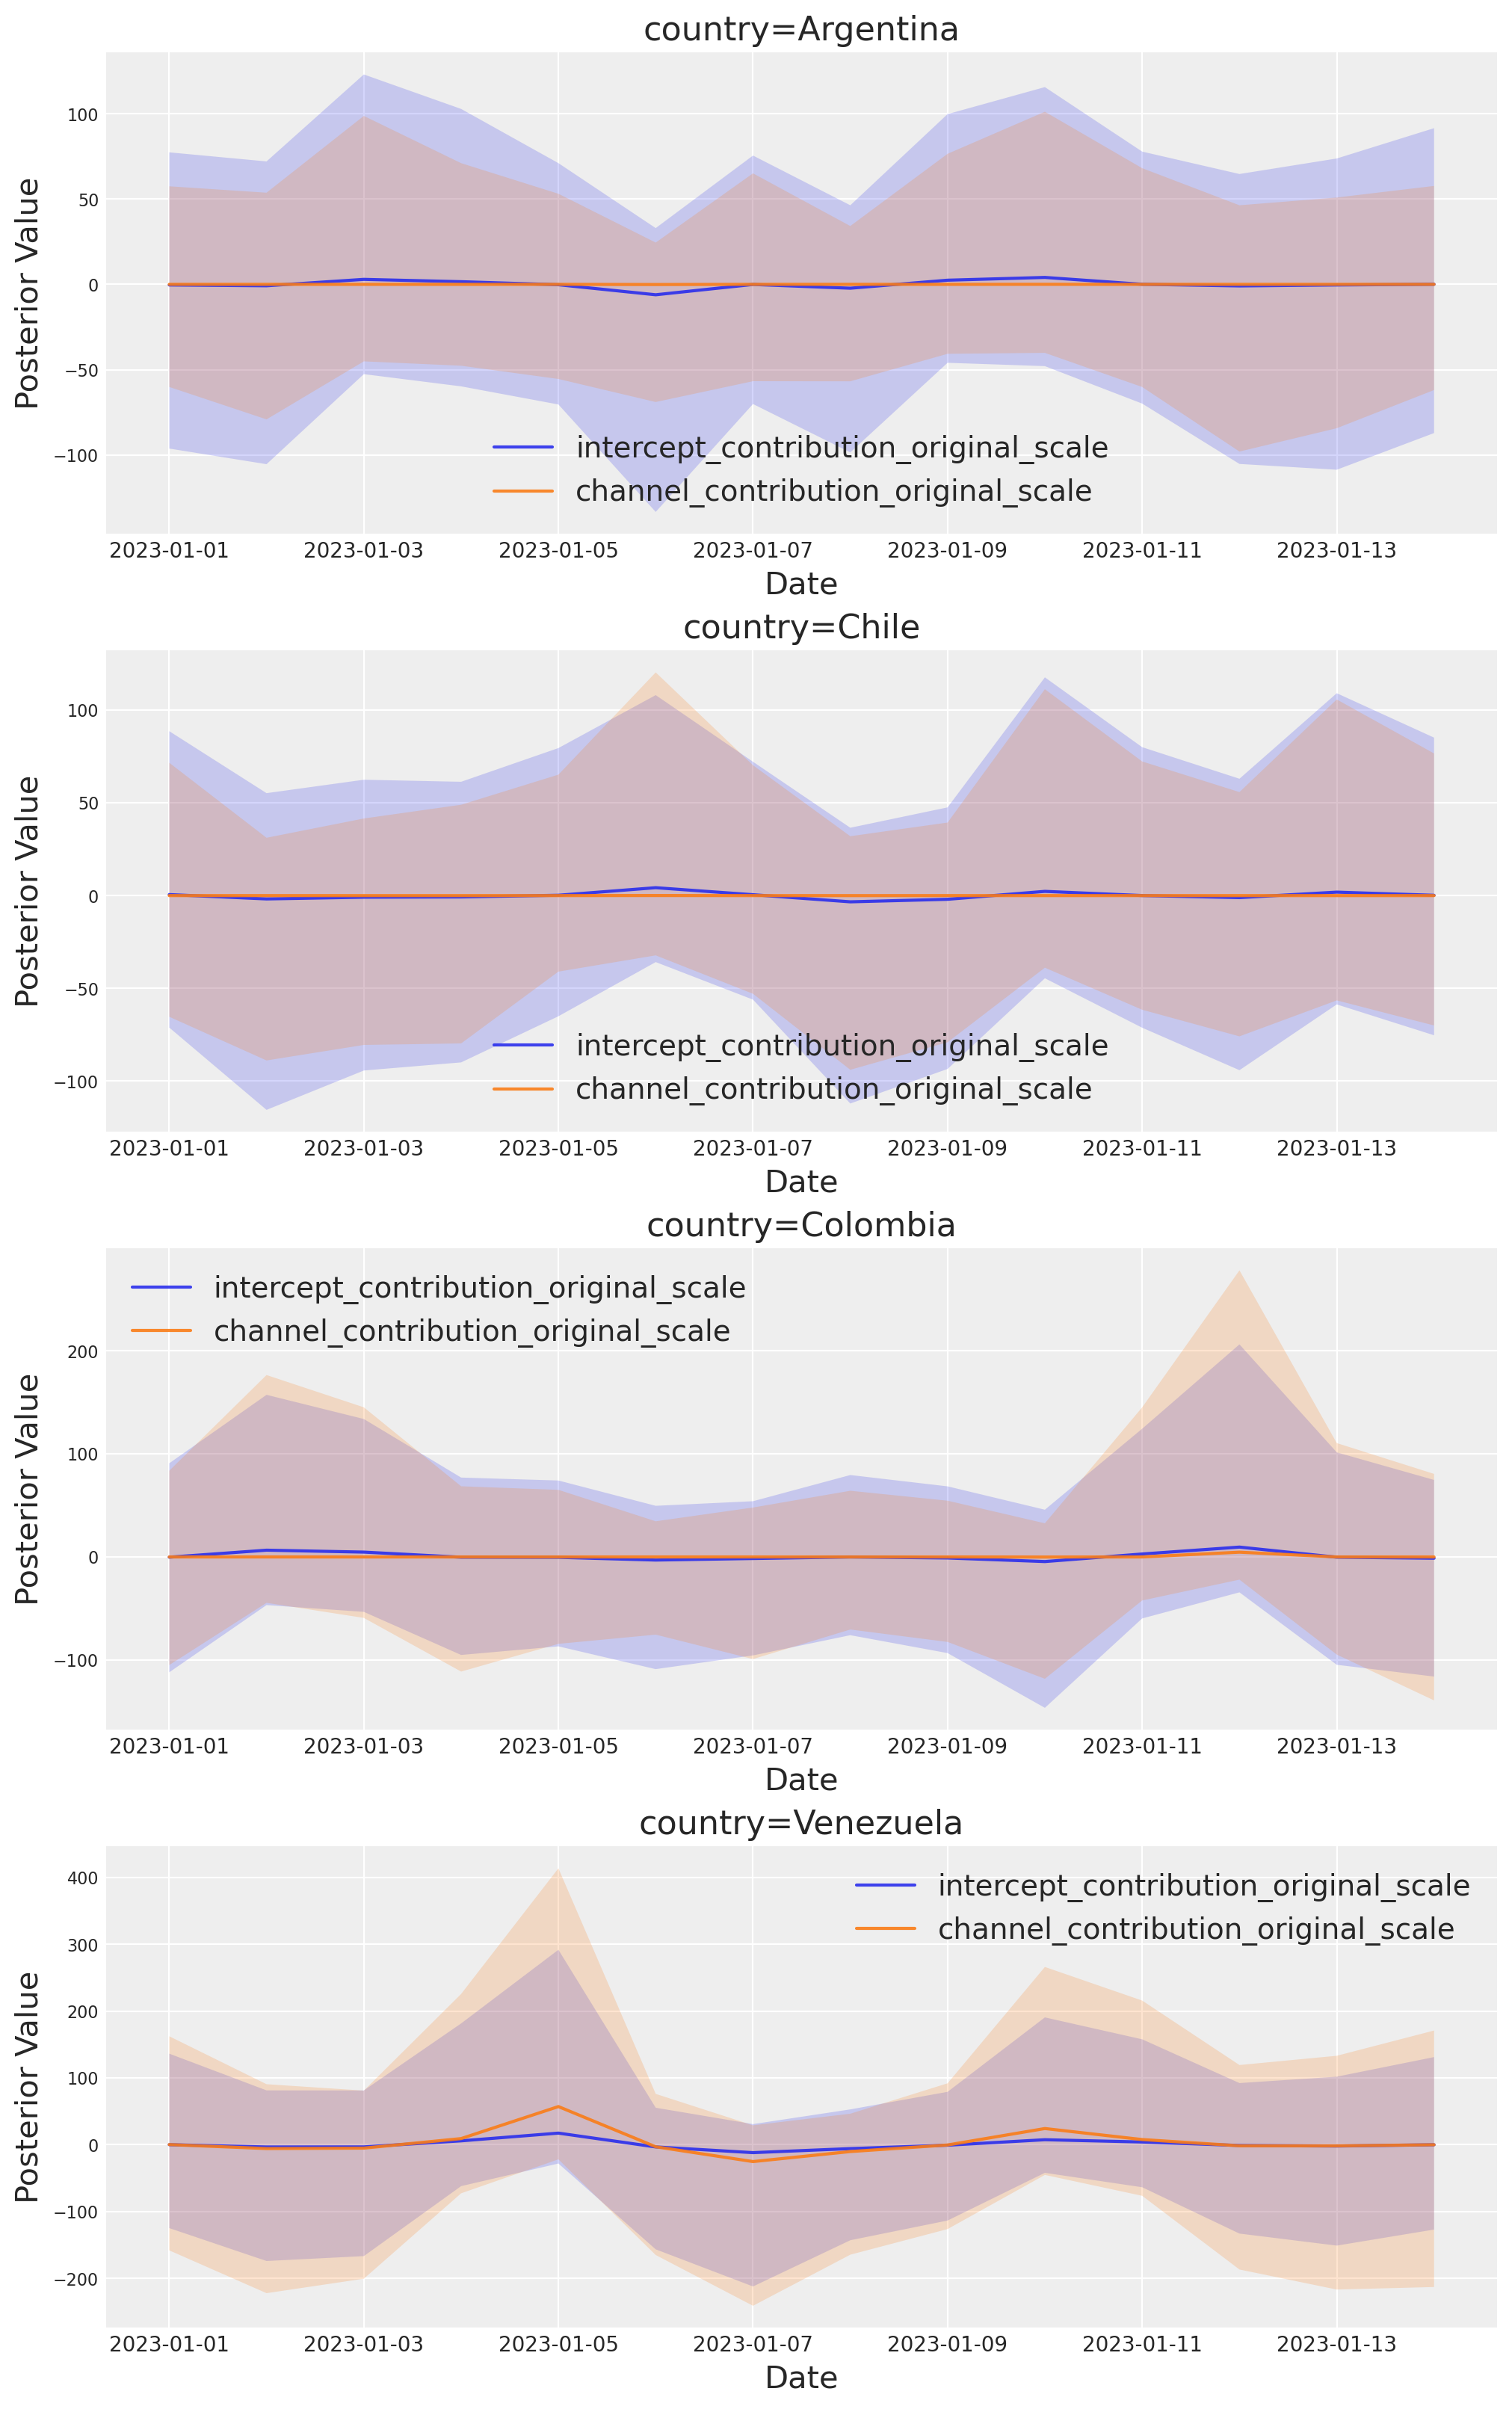

In [21]:
fig, ax = mmm.plot.contributions_over_time(
    var=[
        "intercept_contribution_original_scale",
        "channel_contribution_original_scale",
    ],
    ci=0.85,
)
# fig.set_size_inches(13, 15)

# # Change the size of the axis letters to be smaller
# for axis in ax.flatten():
#     axis.tick_params(axis="both", which="major", labelsize=10)
#     axis.tick_params(axis="both", which="minor", labelsize=8)

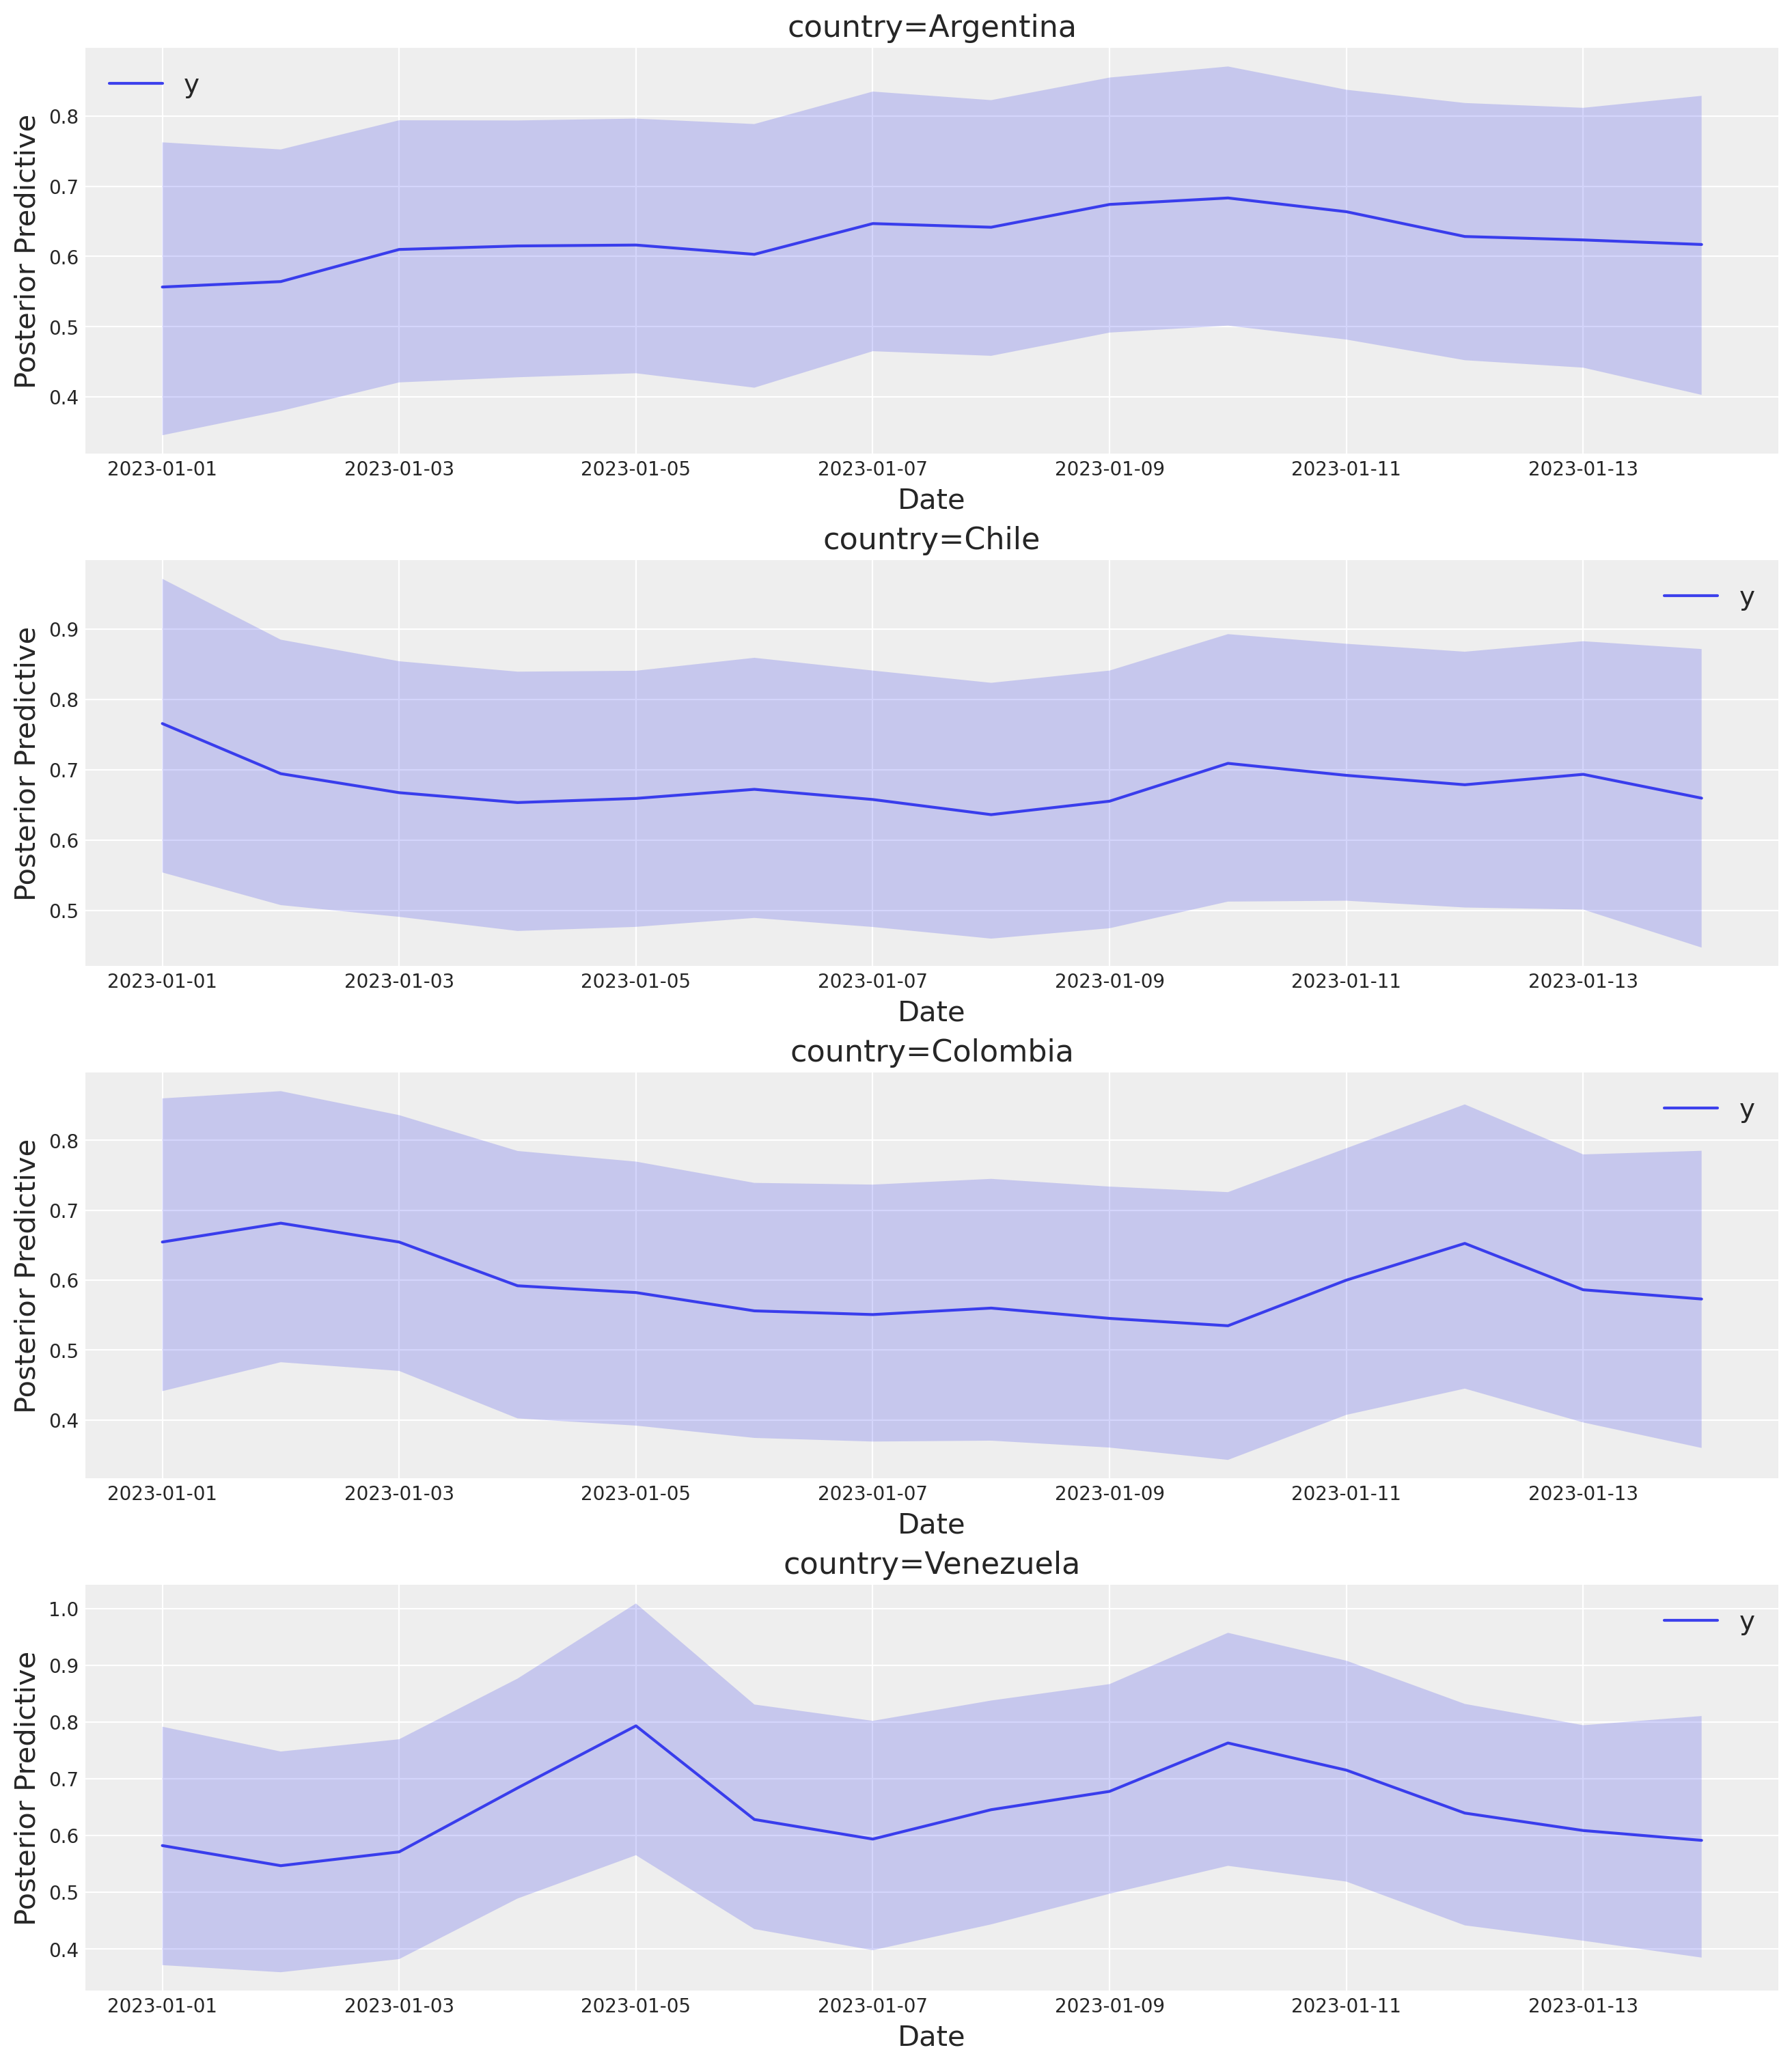

In [22]:
fig, ax = mmm.plot.posterior_predictive()
fig.set_size_inches(13, 15)

# Change the size of the axis letters to be smaller
for axis in ax.flatten():
    axis.tick_params(axis="both", which="major", labelsize=10)
    axis.tick_params(axis="both", which="minor", labelsize=8)

In [23]:
_y_out_sample = mmm.sample_posterior_predictive(
    X=df_test.drop(columns="target"),
    y=None,
    extend_idata=False,
    include_last_observations=False,
    random_seed=42,
    var_names=["channel_contribution", "intercept_contribution"],
)
_y_out_sample

Sampling: []


Output()

ValueError: Input dimension mismatch: (input[%i].shape[%i] = %lld, input[%i].shape[%i] = %lld)
Apply node that caused the error: Composite{(((i2 * i1) / (i0 + i1)) * i3)}(ExpandDims{axes=[0, 1]}.0, Transpose{axes=[2, 0, 1]}.0, DimShuffle{order=[x,1,0]}.0, ExpandDims{axis=2}.0)
Toposort index: 37
Inputs types: [TensorType(float64, shape=(1, 1, None)), TensorType(float64, shape=(None, None, None)), TensorType(float64, shape=(1, None, None)), TensorType(float64, shape=(14, None, 1))]
Inputs shapes: [(1, 1, 2), (16, 4, 2), (1, 4, 2), (14, 4, 1)]
Inputs strides: [(16, 16, 8), (8, 256, 128), (32, 8, 32), (32, 8, 8)]
Inputs values: [array([[[0.82987674, 0.0813621 ]]]), 'not shown', 'not shown', 'not shown']
Outputs clients: [[output[0](channel_contribution)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [28]:
mmm._time_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [23]:
mmm.saturation

MichaelisMentenSaturation(prefix='saturation', priors={'alpha': Prior("Gamma", mu=Prior("HalfNormal", sigma=1, dims="country"), sigma=Prior("HalfNormal", sigma=1, dims="country"), dims=("channel", "country")), 'lam': Prior("HalfNormal", sigma=1, dims="channel")})

In [24]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    # dims=("country",),
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
)

# df.drop(columns="country", inplace=True)

In [25]:
mmm.fit(
    X=df.drop(columns=["country", "target"]), y=df.drop(columns=[*channels, "country"])
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_alpha, saturation_lam, y_sigma]
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

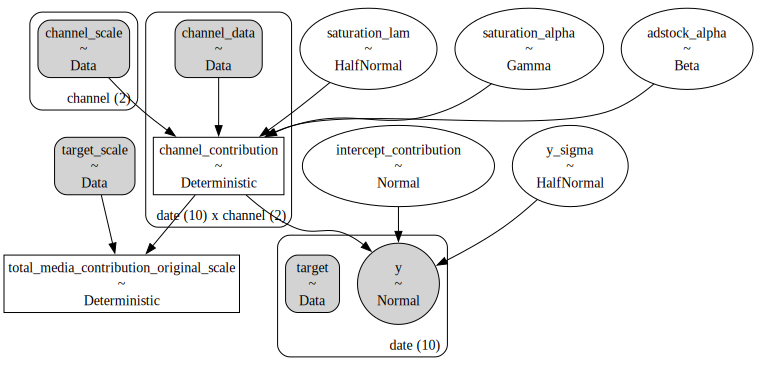

In [26]:
pm.model_to_graphviz(mmm.model)